# U-Net com EfficientNet como *backbone*

EfficientNet é uma arquitetura de rede neural convolucional que dimensiona uniformemente profundidade/largura/resolução usando um coeficiente composto. Ao contrário do que se faz convencionalmente (dimensionamento arbitrário destes fatores), o método de dimensionamento EfficientNet dimensiona uniformemente a largura, a profundidade e a resolução da rede com um conjunto de coeficientes fixos.

O método de dimensionamento composto é justificado pela intuição de que, se a imagem de entrada for maior, a rede precisa de mais camadas para aumentar o campo receptivo e mais canais para capturar padrões mais refinados na imagem maior. A "rede base" *EfficientNet-B0* é baseada nos blocos residuais de gargalo invertidos do MobileNetV2.

Neste contexto, os autores projetaram as EfficientNets, que alcançam precisão e eficiência muito melhores do que as ConvNets anteriores. Em particular, a EfficientNet-B7 atinge 84,3% de precisão top-1 de última geração no ImageNet, sendo **8,4x menor e 6,1x mais rápido** na inferência do que o melhor ConvNet existente.

As EfficientNets também transferem bem e alcançam precisão de última geração em CIFAR-100 (91,7%), Flowers (98,8%) e 3 outros conjuntos de dados de aprendizado de transferência, com uma ordem de magnitude a menos de parâmetros [1].

## U-Net

U-Net foi proposta tendo como objetivo a segmentação de imagens biomédicas. Porém, a medida que ganhou popularidade, foi sendo aplicada em diferentes contextos, apresentando bons resultados nestas situações.

A rede consiste em um caminho de contração (diminuição da resolução - *encoder*) e um caminho expansivo (aumento da resolução - *decoder*), o que lhe confere a arquitetura em forma de "U". O caminho de contração é uma rede convolucional típica que consiste na aplicação repetida de convoluções, cada uma seguida por uma *rectified linear unit* (ReLU) e uma operação de *max pooling*. Durante a contração, a informação espacial é reduzida enquanto a informação da característica é aumentada. O caminho expansivo combina o recurso e as informações espaciais por meio de uma sequência de convoluções e concatenações ascendentes com recursos de alta resolução do caminho de contração [2].

[[1] TAN, Mingxing; LE, Quoc. Efficientnet: Rethinking model scaling for convolutional neural networks. In: **International conference on machine learning.** PMLR, 2019. p. 6105-6114.](http://proceedings.mlr.press/v97/tan19a.html)

[[2] RONNEBERGER, Olaf; FISCHER, Philipp; BROX, Thomas. U-net: Convolutional networks for biomedical image segmentation. In: **International Conference on Medical image computing and computer-assisted intervention**. Springer, Cham, 2015. p. 234-241.](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)

## *Backbones* Customizados

O que se faz hoje em dia é substituir a estrutura original de camadas de rede propostas pelos pesquisadores da Univ. de Freiburg por duas versões de uma rede neural mais poderosa (uma normal e uma "invertida"), aplicando as alterações de arquitetura necessárias para que o princípio de funcionamento de U-Net seja mantido, como conexões laterais horizontais entre as duas redes, descendente e ascendente.

No caso deste notebook estamos usando como backbone uma versão melhorada de EfficientNet, que inclui estratégias de gerenciamento de taxa de aprendizado e momento como 1cycle.

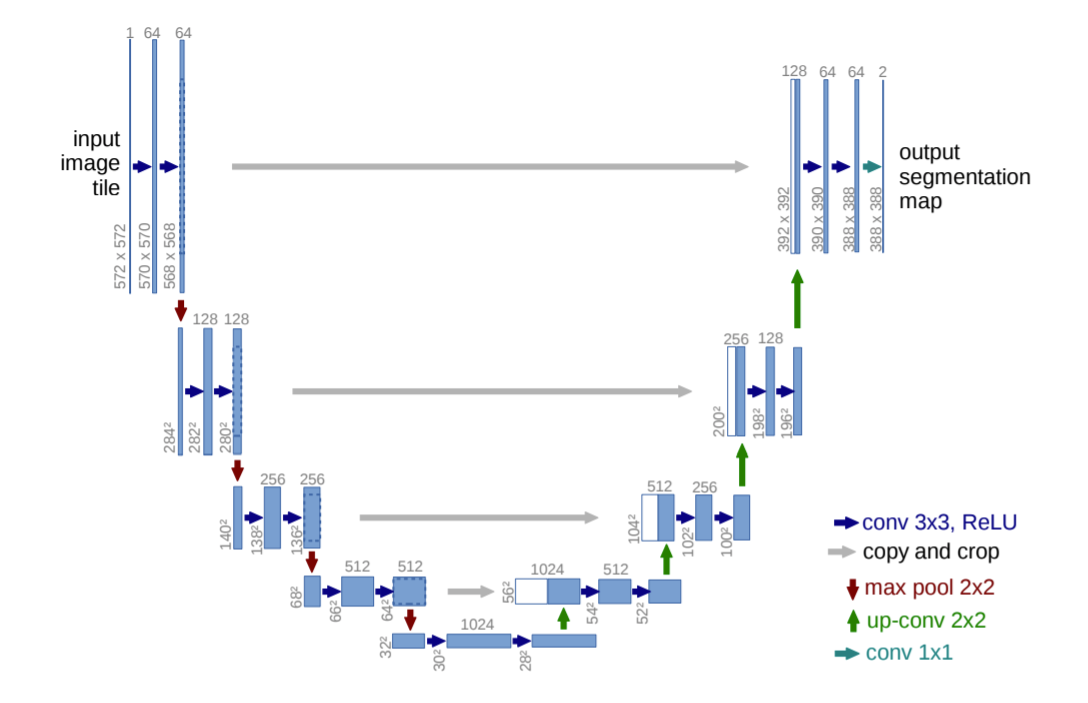

In [2]:
!nvidia-smi

Thu Sep  4 18:37:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:1B:00.0 Off |                    0 |
| N/A   54C    P0            571W /  700W |   74700MiB /  81559MiB |     91%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix/compartilhado/beatriz/placenta/efficient" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [2] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Running on Google Colab =  False
CUDA GPUS NUMBER:  1


# Suprimir Avisos Gerais na saida do notebook
Suprimir apenas "avisos", erros irá mostrar a causar e efetuará a parada do notebook normalmente.

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Montando o Google Drive
Para salvar no google drive execute a celula abaixo para montar o drive e atualize os caminhos de salvamento dos notebook.

In [ ]:
'''from google.colab import drive
DRIVE_PATH = os.path.join(BASE_PATH, "gdrive")
drive.mount(DRIVE_PATH)

# Instalando as bibliotecas necessárias
Algumas bibliotecas já estão instaladas por padrão na plataforma. Porém, aquelas que são menos usuais podem ser instaladas via *pip* (gerenciador de pacotes do Python).

In [5]:
INSTALL_LIBS = True # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install lapixdl
    !pip install -U albumentations
    !pip install fastai
    !pip install wandb -qU
    !pip install -q efficientunet-pytorch

_wandb = False

DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/paddleseg-0.0.0.dev0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/paddleseg-0.0.0.dev0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.20
    Uninstalling albucore-0.0.20:
      Successfully uninstalled albucore-0.0.20
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.21
    Uninstalli

# OPCIONAL: Utilizar WandB
*   Software para visualizar métricas e compara-los entre experimentos.
*   https://wandb.ai/site
*   Obs: Necessário criar uma conta e gerar um token de acesso.




In [6]:
# Opcional Usar WandB para logar dados de treino
import wandb
_wandb = True
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: belopes (belopes-universidade-federal-de-santa-catarina) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Importando as bibliotecas necessárias

In [7]:
import os
import cv2
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from collections import defaultdict
from datetime import datetime

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from efficientunet import *

from lapixdl.evaluation.evaluate import evaluate_segmentation

# Baixando o conjunto de Dados

# Parte #0 - Definindo alguns parâmetros...
Para facilitar os experimentos, foram definido diversos parâmetros (variáveis). Assim, caso deseje-se fazer um experimento com outra configuração/cenário, basta configurar estas variáveis de acordo.

In [8]:
# USE_MULTIRESOLUTION_TRAINING: É uma flag que indica se a rede será treinada com a estratégia de aumento progressivo de resolução.

# ==========================================================================================================================================

# CONCEITOS
# - Rede "congelada"   : as primeiras camadas da rede neural não são treinadas.
# - Rede "descongelada": todas as camadas da rede neural serão treinadas.

# Caso #1: USE_MULTIRESOLUTION_TRAINING = True
# Caso a flag seja "True", a rede neural será treinada utilizando a estratégia de multiresolução.
# Ex.: São 3 estágios, com duas etapas cada um. Na primeira etapa do primeiro estágio, a rede neural será treinada por TRAIN_EPOCHS épocas, com as imagens
# possuindo 1/4 de sua resolução original. Além disso, serão treinadas apenas algumas camadas da rede neural. O "encoder" será congelado e não será treinado.
# Já na segunda etapa do primeiro estágio, a rede será "descongelada" e serão treinadas todas as camadas da rede neural.
# A rede neural será treinada por FINE_TUNING_EPOCHS épocas, onde a resolução das imagens continua sendo 1/4 da resolução original.

# Na primeira etapa do segundo estágio, a resolução das imagens será de 1/2 de sua resolução original. Além disso, o treino ocorre
# novamente por 15 épocas, com parte da rede congelada. Na segunda etapa do segundo estágio, a rede é treinada por FINE_TUNING_EPOCHS épocas, totalmente descongelada.

# Na primeira etapa do terceiro estágio, a rede é treinada com sua resolução original. O treino ocorre por TRAIN_EPOCHS épocas, com parte da rede congelada.
# Na segunda etapa do terceiro estágio, a rede é treinada por FINE_TUNING_EPOCHS épocas, totalmente descongelada, com a resolução original.

# ==========================================================================================================================================

# Caso #2: USE_MULTIRESOLUTION_TRAINING = False
# Caso USE_MULTIRESOLUTION_TRAINING = False, a rede neural será treinada pela quantidade de épocas configurada em EPOCHS,
# com a resolução configurada em ORIGINAL_RESOLUTION.

# ==========================================================================================================================================

USE_MULTIRESOLUTION_TRAINING = True

# Resolução original das imagens
ORIGINAL_RESOLUTION = (512, 512)

# Quantidade de épocas de treinamento - caso USE_MULTIRESOLUTION_TRAINING = False
EPOCHS = 50

# Quantidade de épocas de treinamento para as etapas #1 e #2 de cada estágio - caso USE_MULTIRESOLUTION_TRAINING = True
TRAIN_EPOCHS = 50
FINE_TUNING_EPOCHS = 50

In [9]:
# Define a taxa de aprendizado de cada grupo de parâmetros de acordo com a "1Cycle Learning Rate Policy".
# A política de 1Cycle varia/aumenta a taxa de aprendizado de um valor inicial para um valor final (máxima) e, em seguida,
# diminui da taxa de aprendizado máxima para uma taxa de aprendizado mínima muito inferior à taxa de aprendizado inicial.
# Essa política foi descrita inicialmente no artigo Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates (https://arxiv.org/abs/1708.07120).

USE_ONE_CYCLE_POLICY = True

if not USE_ONE_CYCLE_POLICY:
    scheduler = None

In [10]:
# A rede neural EfficientNet possui diferentes profundidades. Seus modelos variam de B0 (mais rasa) até B7 (mais profunda).
# Desta maneira, a variável EFFICIENTNET_MODEL indica qual dos modelos foi o escolhido. Assim, de acordo com o modelo configurado em EFFICIENTNET_MODEL,
# o método para download do modelo pré-treinado é dado pelo dicionário 'cnn_download_method'.

EFFICIENTNET_MODEL = 0

cnn_download_method = {
    0: get_efficientunet_b0,
    1: get_efficientunet_b1,
    2: get_efficientunet_b2,
    3: get_efficientunet_b3,
    4: get_efficientunet_b4,
    5: get_efficientunet_b5,
    6: get_efficientunet_b6,
    7: get_efficientunet_b7
}

In [11]:
# Quantidade de classes para as quais a rede neural vai ser treinada
N_CLASSES = 10

# Definindo o ROOT_DIRECTORY para apontar para a pasta "dataset"
ROOT_DIRECTORY = os.path.join(BASE_PATH, "dataset")

# É a pasta que contém as imagens. Deve estar dentro de ROOT_DIRECTORY
IMAGES_FOLDER = "images"

# É a pasta que contém as anotações. Deve estar dentro de ROOT_DIRECTORY
LABELS_FOLDER = "label"

# Tamanho do batch size (quantidade de imagens que serão submetidas à rede neural por iteração)
BATCH_SIZE = 16

# Learning Rate (Taxa de aprendizado)
LR = 0.0001

# Apenas separando os valores configurados como resolução original
ORIGINAL_IMAGE_WIDTH = ORIGINAL_RESOLUTION[0]
ORIGINAL_IMAGE_HEIGHT = ORIGINAL_RESOLUTION[1]

# Local onde será salvo o modelo treinado da rede neural, agora dentro de dataset
date_now = datetime.now().strftime('%Y%m%d%H%M%S')
MODEL_SAVE_PATH = os.path.join(ROOT_DIRECTORY, "output/models", date_now)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
print(f"MODEL_SAVE_PATH: {MODEL_SAVE_PATH}")

# Nome do arquivo contendo os pesos da rede neural treinada
MODEL_NAME = f"efficientnetb{EFFICIENTNET_MODEL}_{N_CLASSES}_classes"
if USE_MULTIRESOLUTION_TRAINING:
    MODEL_NAME += "multiresolution_"
MODEL_NAME += f"{ORIGINAL_IMAGE_WIDTH}_{ORIGINAL_IMAGE_HEIGHT}_{EPOCHS}_epochs.pth"


MODEL_SAVE_PATH: /lapix/compartilhado/beatriz/placenta/efficient/dataset/output/models/20250904183935


In [12]:
GENERATE_MASKS = True

PATH_TO_SAVE_MASK = os.path.join(BASE_PATH, f"ResultadoImagens/{date_now}")
PATH_TO_SAVE_MASK = os.path.join(PATH_TO_SAVE_MASK, MODEL_NAME.replace(".pth", ""))

os.makedirs(PATH_TO_SAVE_MASK, exist_ok=True)

In [13]:
# Definindo as classes para o dataset da placenta
import numpy as np

codes = np.array([
    'background',
    'cordao_umbilical_fetal',
    'cordao_umbilical_materno',
    'disco_discoide_fetal',
    'disco_discoide_materno',
    'disco_irregular_fetal',
    'disco_irregular_materno',
    'disco_ovalada_fetal',
    'disco_ovalada_materno',
    'vasos_arboriforme'
])

print(f"Classes definidas: {codes}")

Classes definidas: ['background' 'cordao_umbilical_fetal' 'cordao_umbilical_materno'
 'disco_discoide_fetal' 'disco_discoide_materno' 'disco_irregular_fetal'
 'disco_irregular_materno' 'disco_ovalada_fetal' 'disco_ovalada_materno'
 'vasos_arboriforme']


In [14]:
def normalize_colors(cmap_colors):
    return [tuple(color / np.sum(rgb_color) if color != 0 else 0.0 for color in rgb_color) for rgb_color in cmap_colors]

# Nome do mapa de cores personalizado
cmap_name = 'CustomColors'

# Definindo o mapeamento de cores para as classes do dataset
color_map = {
            10: (  0,   0,   0), # background
            11: (  25,   70,   90), # cordao_umbilical_fetal
            12: (  0, 129,  35), # cordao_umbilical_materno
            13: (215, 191,  66), #  disco_discoide_fetal
            14: (166, 148, 241), # disco_discoide_materno
            15: (157, 134, 124), # disco_irregular_fetal
            16: (131,  86,  58), # disco_irregular_materno
            17: (107,  50, 148), # disco_ovalada_fetal
            18: ( 81, 114, 213), # disco_ovalada_materno
            19: (102,  43, 107),  # vasos_arboriforme
        }

# Gerar o array de cores
cmap_colors = [color_map[idx] for idx in color_map.keys()]

# Criar o dicionário final com as configurações do colormap
custom_colormap = {
    'cmap_colors': cmap_colors,
    'colors_norm': normalize_colors(cmap_colors),
    'cmap': LinearSegmentedColormap.from_list(cmap_name, normalize_colors(cmap_colors)),
    'class_names': codes
}

print(f"Colormap definido com sucesso: {list(color_map.values())}")

Colormap definido com sucesso: [(0, 0, 0), (25, 70, 90), (0, 129, 35), (215, 191, 66), (166, 148, 241), (157, 134, 124), (131, 86, 58), (107, 50, 148), (81, 114, 213), (102, 43, 107)]


## Concatenando as *strings* dos caminhos (*paths*)
Os caminhos para leitura das imagens e anotações do conjunto de dados foram definidos através de variáveis. A função *join* da biblioteca *os* tem como função concatenar estas duas *strings*, levando em conta o sistema operacional em que está sendo executado. O Windows tem um padrão de caminhos separado por duas barras invertidas (\\\\) e o Linux uma barra apenas (/).

In [15]:
ROOT_DIRECTORY = os.path.join(BASE_PATH, "dataset")

images_directory = os.path.join(ROOT_DIRECTORY, IMAGES_FOLDER)
masks_directory = os.path.join(ROOT_DIRECTORY, LABELS_FOLDER)

## Definindo os parâmetros de treinamento e teste da rede neural
Aqui é criado um dicionário para agrupar diversos parâmetros configurados no início deste notebook. O *device* indica onde a rede neural será treinada (`"cuda"` para GPU e `"cpu"` caso a placa de vídeo não seja utilizada).

In [16]:
params = {
    "device": "cuda",
    "lr": LR,
    "batch_size": BATCH_SIZE,
    "num_workers": 2,
    "epochs": EPOCHS,
}

In [17]:
# opcional se estiver logando com wandb
if _wandb:
    wandb.init(project="efficient", name=f"efficientnetb{EFFICIENTNET_MODEL}_1cyclepolicy_{N_CLASSES}_classes", config={"learning_rate": LR, "architecture": "unet_efficientnet", "dataset": "dataset", "epochs": EPOCHS, "batch_size": BATCH_SIZE })

## Calculando a quantidade de imagens para treino/teste/validação

Para uma avaliação sem vieses dos resultados da rede neural, é necessário dividir o conjunto de dados em 'treinamento' e 'teste'. O conjunto de treinamento será utilizado para ajustar os pesos da rede neural. Já o conjunto de teste será utilizado para avaliar os resultados, tanto visualmente quanto por meio de métricas.

In [18]:
number_of_images = len(os.listdir(images_directory))
number_of_test_images = int(number_of_images * 0.1)
number_of_val_images = int(number_of_images * 0.1)
number_of_train_images = number_of_images - number_of_val_images - number_of_test_images
print(f"Quantidade de imagens no dataset de treino: {number_of_train_images}")
print(f"Quantidade de imagens no dataset de validação: {number_of_val_images}")
print(f"Quantidade de imagens no dataset de teste: {number_of_test_images}")

Quantidade de imagens no dataset de treino: 377
Quantidade de imagens no dataset de validação: 46
Quantidade de imagens no dataset de teste: 46


## Lendo os dados do disco e realizando a separação
Anteriomente foi feito o cálculo de quantas imagens deveriam ser utilizadas para treinamento, validação e teste. Agora, é necessário, de fato, dividir estas imagens nestes grupos. A função `random.seed(42)` tem como objetivo configurar uma *seed* (semente) para a função *shuffle* (embaralhamento). Isso garante a reprodutibilidade dos experimentos, já que essa separação será sempre igual, independente de onde este notebook está sendo executado.

In [19]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:number_of_train_images]
val_images_filenames = correct_images_filenames[number_of_train_images:-number_of_val_images]
test_images_filenames = images_filenames[-number_of_test_images:]

print(f"Quantidade de imagens no dataset de treino: {len(train_images_filenames)}")
print(f"Quantidade de imagens no dataset de validação: {len(val_images_filenames)}")
print(f"Quantidade de imagens no dataset de teste: {len(test_images_filenames)}")

Quantidade de imagens no dataset de treino: 377
Quantidade de imagens no dataset de validação: 45
Quantidade de imagens no dataset de teste: 46


# Parte #1 - Treinando a rede neural
Nesta seção do notebook será executado o treinamento da rede neural.

## Visualizando as imagens e suas anotações
O método `display_image_grid` apresenta um conjunto aleatório de imagens. O objetivo é apenas a inspeção visual delas, assim como suas máscaras.

In [20]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = min(len(images_filenames), 5)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 36))
    for i in range(rows):
        image = cv2.imread(os.path.join(images_directory, images_filenames[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, images_filenames[i].replace(".jpg", "_mask.png")), cv2.IMREAD_UNCHANGED)

        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

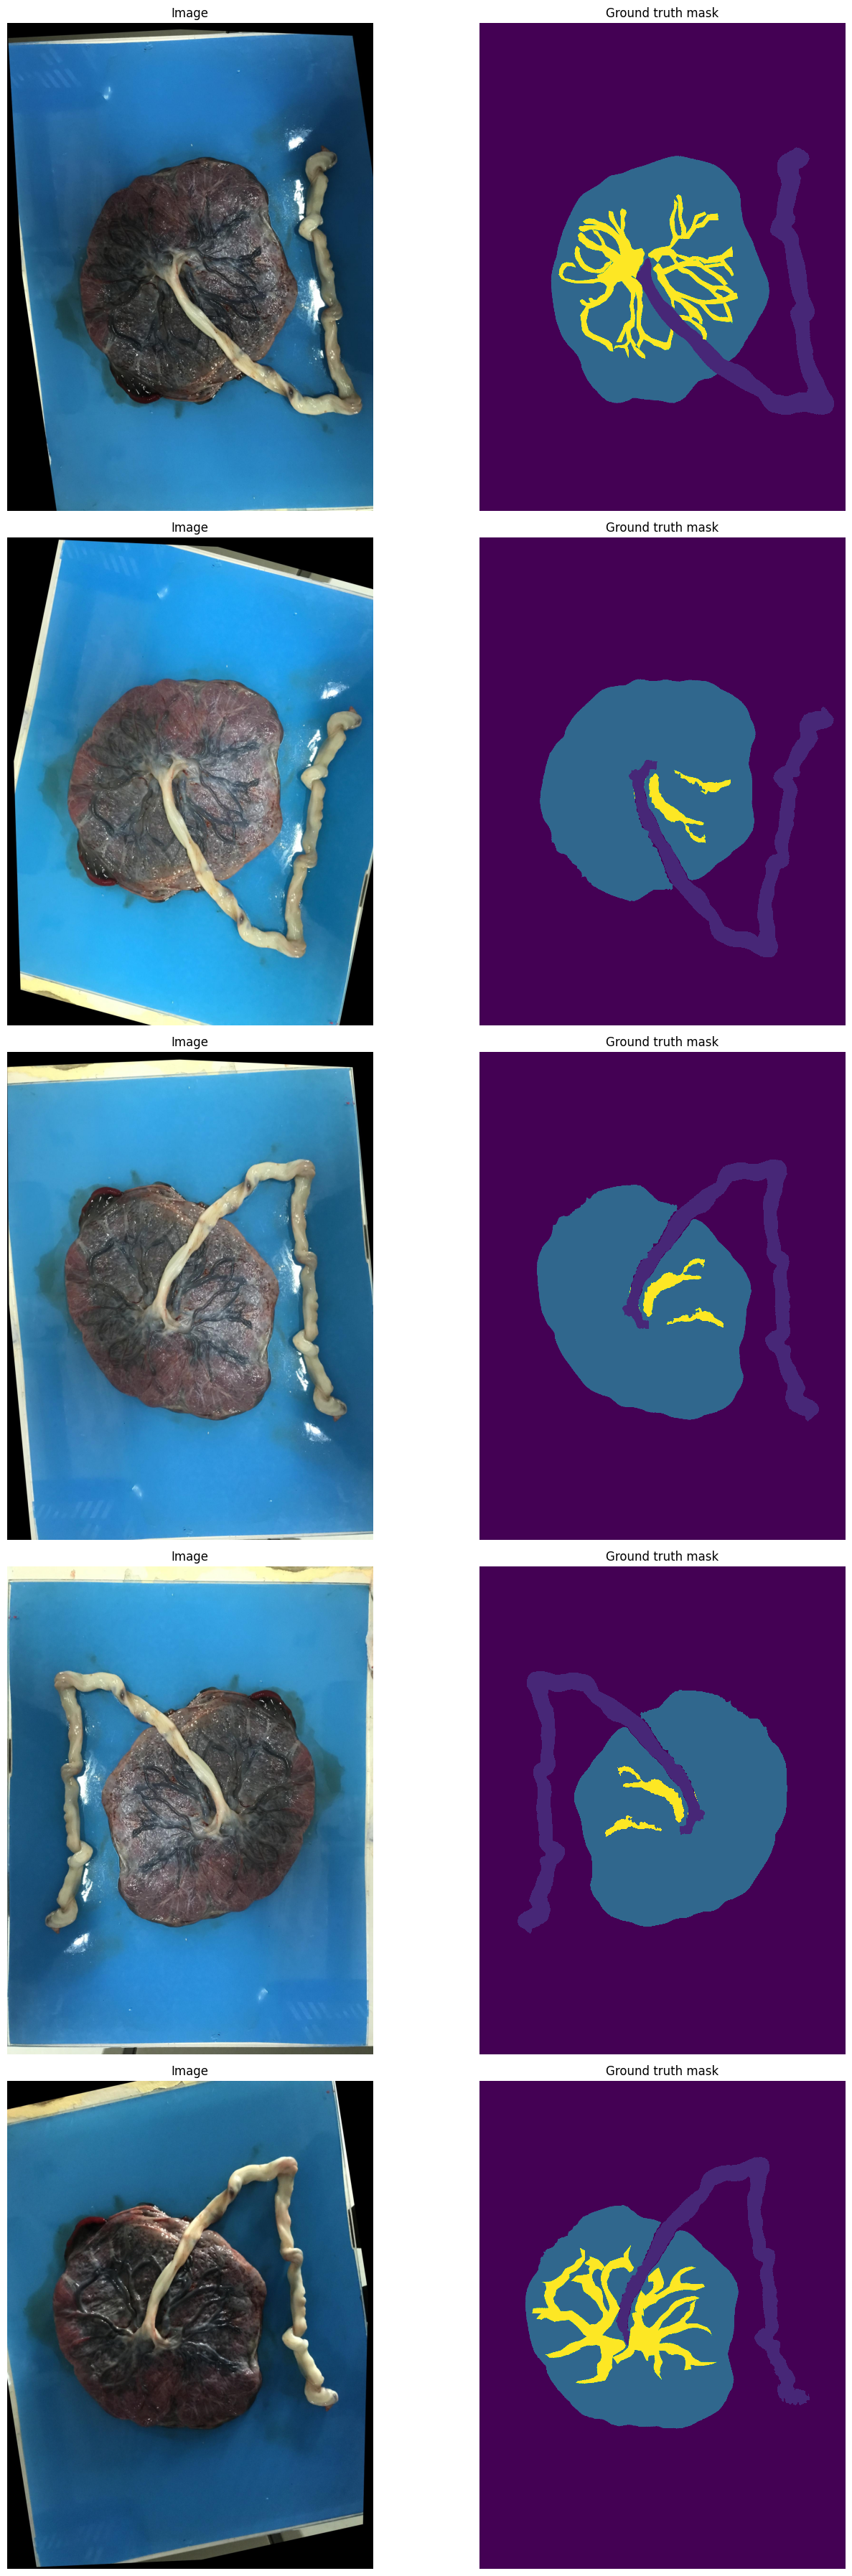

In [21]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

## Declarando a classe que fara o *parsing* do conjunto de dados
No PyTorch é necessário que se defina uma classe para ler e interpretar os dados de treinamento e teste da rede neural. Sendo assim, foi declarada a classe `SemanticSegmentationDataset`, que herda a classe `Dataset`, nativa do PyTorch.

In [22]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", "_mask.png")), cv2.IMREAD_UNCHANGED,
        )

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

## Declarando método responsável pelo cálculo das métricas de desempenho
Para controle do treinamento, é necessário calcular algumas métricas durante cada época. A classe `MetricMonitor` possui alguns métodos para este fim.

In [23]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [24]:
import numpy as np
import torch
import torch.nn as nn


class SegmentationMetrics(object):
    r"""
    Args:
        eps: float, a value added to the denominator for numerical stability.
            Default: 1e-5

        average: bool. Default: ``True``
            When set to ``True``, average Dice Coeff, precision and recall are
            returned. Otherwise Dice Coeff, precision and recall of each class
            will be returned as a numpy array.

        ignore_background: bool. Default: ``True``
            When set to ``True``, the class will not calculate related metrics on
            background pixels. When the segmentation of background pixels is not
            important, set this value to ``True``.

        activation: [None, 'none', 'softmax' (default), 'sigmoid', '0-1']
            This parameter determines what kind of activation function that will be
            applied on model output.

    Input:
        y_true: :math:`(N, H, W)`, torch tensor, where we use int value between (0, num_class - 1)
        to denote every class, where ``0`` denotes background class.
        y_pred: :math:`(N, C, H, W)`, torch tensor.

    Examples::
        >>> metric_calculator = SegmentationMetrics(average=True, ignore_background=True)
        >>> pixel_accuracy, dice, iou = metric_calculator(y_true, y_pred)
    """
    def __init__(self, eps=1e-5, average=True, ignore_background=True, activation='0-1'):
        self.eps = eps
        self.average = average
        self.ignore = ignore_background
        self.activation = activation

    @staticmethod
    def _one_hot(gt, pred, class_num):
        # transform sparse mask into one-hot mask
        # shape: (B, H, W) -> (B, C, H, W)
        input_shape = tuple(gt.shape)  # (N, H, W, ...)
        new_shape = (input_shape[0], class_num) + input_shape[1:]
        one_hot = torch.zeros(new_shape).to(pred.device, dtype=torch.float)
        target = one_hot.scatter_(1, gt.unsqueeze(1).long().data, 1.0)
        return target

    @staticmethod
    def _get_class_data(gt_onehot, pred, class_num):
        # perform calculation on a batch
        # for precise result in a single image, plz set batch size to 1
        matrix = np.zeros((3, class_num))

        # calculate tp, fp, fn per class
        for i in range(class_num):
            # pred shape: (N, H, W)
            class_pred = pred[:, i, :, :]
            # gt shape: (N, H, W), binary array where 0 denotes negative and 1 denotes positive
            class_gt = gt_onehot[:, i, :, :]

            pred_flat = class_pred.contiguous().view(-1, )  # shape: (N * H * W, )
            gt_flat = class_gt.contiguous().view(-1, )  # shape: (N * H * W, )

            tp = torch.sum(gt_flat * pred_flat)
            fp = torch.sum(pred_flat) - tp
            fn = torch.sum(gt_flat) - tp

            matrix[:, i] = tp.item(), fp.item(), fn.item()

        return matrix

    def _calculate_multi_metrics(self, gt, pred, class_num):
        # calculate metrics in multi-class segmentation
        matrix = self._get_class_data(gt, pred, class_num)
        if self.ignore:
            matrix = matrix[:, 1:]

        pixel_acc = (np.sum(matrix[0, :]) + self.eps) / (np.sum(matrix[0, :]) + np.sum(matrix[1, :]))
        dice = (2 * matrix[0] + self.eps) / (2 * matrix[0] + matrix[1] + matrix[2] + self.eps)
        iou = (matrix[0] + self.eps) / (matrix[0] + matrix[1] + matrix[2] + self.eps)

        if self.average:
            dice = np.average(dice)
            iou = np.average(iou)

        return pixel_acc, dice, iou

    def __call__(self, y_true, y_pred):
        class_num = y_pred.size(1)

        if self.activation in [None, 'none']:
            activation_fn = lambda x: x
            activated_pred = activation_fn(y_pred)
        elif self.activation == "sigmoid":
            activation_fn = nn.Sigmoid()
            activated_pred = activation_fn(y_pred)
        elif self.activation == "softmax":
            activation_fn = nn.Softmax(dim=1)
            activated_pred = activation_fn(y_pred)
        elif self.activation == "0-1":
            pred_argmax = torch.argmax(y_pred, dim=1)
            activated_pred = self._one_hot(pred_argmax, y_pred, class_num)
        else:
            raise NotImplementedError("Not a supported activation!")

        gt_onehot = self._one_hot(y_true, y_pred, class_num)
        pixel_acc, dice, iou = self._calculate_multi_metrics(gt_onehot, activated_pred, class_num)
        return pixel_acc, dice, iou

In [25]:
semantic_segmentation_metrics = SegmentationMetrics(average=True, ignore_background=True)

## Definindo os métodos de treinamento e validação
Além do treino "comum" das redes neurais, também foi implementado o método de treinamento multiresolução. Sendo assim, para melhor legibilidade e manutenção do código, separou-se o *loop* de treinamento e validação da rede neural nos métodos `train` e `validate`.

In [26]:
def train(train_loader, model, criterion, optimizer, epoch, params, n_classes, scheduler=None):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        if n_classes > 1:
            target = target.to(params["device"], non_blocking=True).long()
        else:
            target = target.to(params["device"], non_blocking=True).float()
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

    if _wandb:
      wandb.log({"train_loss": metric_monitor.metrics['Loss']['avg']})

In [27]:
def validate(val_loader, model, criterion, epoch, params, n_classes, metric_calculator):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            if n_classes > 1:
                target = target.to(params["device"], non_blocking=True).long()
            else:
                target = target.to(params["device"], non_blocking=True).float()
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            pixel_accuracy, dice, iou = metric_calculator(target, output)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", pixel_accuracy)
            metric_monitor.update("Dice", dice)
            metric_monitor.update("IoU", iou)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

    if _wandb:
      wandb.log({ "val_loss": metric_monitor.metrics['Loss']['avg'], "accuracy": metric_monitor.metrics['Accuracy']['avg'], "dice_multi": metric_monitor.metrics['Dice']['avg'], "jaccard_coeff_multi": metric_monitor.metrics['IoU']['avg']})

## Definindo métodos para congelar a rede neural
Parte da rede neural pode ser "congelada" e não precisa ser treinada. Neste caso, o "encoder" é congelado e apenas as camadas finais da rede são treinadas.

In [28]:
def freeze_encoder(model):
    for name, child in model.named_children():
        if name == 'encoder':
            for param in child.parameters():
                param.requires_grad = False

    return model

## Instanciando a *loss function* (função de perda)
A *loss function* em uma rede neural compara as anotações com a saída (predição da rede neural) e mede a performance da rede neural lidando com os dados de treinamento. No caso de segmentação semântica, as opções de escolha de *loss function* são reduzidas, principalmente no caso de segmentação multiclasse (onde há mais de duas classes - *background* e objeto). Sendo assim, a mais adequada para este cenário é a *Cross Entropy Loss Function*. De maneira geral, ela mede o desempenho de um modelo de classificação (de pixels, neste caso) cuja saída é um valor de probabilidade entre 0 e 1. O valor da *loss function* aumenta à medida que a probabilidade predita pela rede diverge do valor real.

In [29]:
criterion = nn.CrossEntropyLoss().to(params["device"])

## Gerando o *dataloader*
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

O DataLoader é uma classe nativa do PyTorch que tem como objetivo facilitar o acesso aos dados de treinamento e validação da rede neural

### Treinando a rede neural com as imagens `ORIGINAL_RESOLUTION // 4`

Aqui é instanciado o modelo e utiliza-se o método `freeze_encoder` para congelar o "encoder" do modelo.


In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

if USE_MULTIRESOLUTION_TRAINING:
    print("Estágio 1 - Etapa 1")
    model = cnn_download_method[EFFICIENTNET_MODEL](out_channels=N_CLASSES, concat_input=True, pretrained=True).to(params["device"])
    model = freeze_encoder(model)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])

    train_transform = A.Compose(
        [
            A.Resize(ORIGINAL_IMAGE_WIDTH // 4, ORIGINAL_IMAGE_HEIGHT // 4),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
            A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )
    train_dataset = SemanticSegmentationDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

    val_transform = A.Compose(
        [A.Resize(ORIGINAL_IMAGE_WIDTH // 4, ORIGINAL_IMAGE_HEIGHT // 4), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
    )
    val_dataset = SemanticSegmentationDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

    train_loader = DataLoader(
            train_dataset,
            batch_size=params["batch_size"],
            shuffle=True,
            num_workers=params["num_workers"],
            pin_memory=True,
        )

    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

    if USE_ONE_CYCLE_POLICY:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            steps_per_epoch=len(train_loader),
            epochs=TRAIN_EPOCHS
        )

    for epoch in range(1, TRAIN_EPOCHS + 1): # O "+1" é necessário pois o intervalo final da função "range" em Python é excludente
        train(train_loader, model, criterion, optimizer, epoch, params, N_CLASSES, scheduler)
        validate(val_loader, model, criterion, epoch, params, N_CLASSES, semantic_segmentation_metrics)

    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_1_step_1.pth'))

Estágio 1 - Etapa 1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 61.4MB/s]
Epoch: 1. Train.      Loss: 2.328: 100%|██████████| 24/24 [00:07<00:00,  3.02it/s]
Epoch: 1. Validation. Loss: 2.252 | Accuracy: 0.023 | Dice: 0.031 | IoU: 0.016: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]
Epoch: 2. Train.      Loss: 2.161: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]
Epoch: 2. Validation. Loss: 2.044 | Accuracy: 0.062 | Dice: 0.060 | IoU: 0.033: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
Epoch: 3. Train.      Loss: 1.937: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]
Epoch: 3. Validation. Loss: 1.875 | Accuracy: 0.123 | Dice: 0.079 | IoU: 0.045: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
Epoch: 4. Train.      Loss: 1.760: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]
Epoch: 4. Validation. Loss: 1.805 | Accuracy: 0.189 | 

In [31]:
if USE_MULTIRESOLUTION_TRAINING:
    print("Estágio 1 - Etapa 2")
    model = cnn_download_method[EFFICIENTNET_MODEL](out_channels=N_CLASSES, concat_input=True, pretrained=True).to(params["device"])
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_1_step_1.pth')))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])

    if USE_ONE_CYCLE_POLICY:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            steps_per_epoch=len(train_loader),
            epochs=FINE_TUNING_EPOCHS
        )

    for epoch in range(1, FINE_TUNING_EPOCHS + 1): # O "+1" é necessário pois o intervalo final da função "range" em Python é excludente
        train(train_loader, model, criterion, optimizer, epoch, params, N_CLASSES, scheduler)
        validate(val_loader, model, criterion, epoch, params, N_CLASSES, semantic_segmentation_metrics)

    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_1_step_2.pth'))

Estágio 1 - Etapa 2


Epoch: 1. Train.      Loss: 0.210: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]
Epoch: 1. Validation. Loss: 0.207 | Accuracy: 0.781 | Dice: 0.572 | IoU: 0.487: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]
Epoch: 2. Train.      Loss: 0.196: 100%|██████████| 24/24 [00:06<00:00,  3.73it/s]
Epoch: 2. Validation. Loss: 0.214 | Accuracy: 0.762 | Dice: 0.568 | IoU: 0.471: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
Epoch: 3. Train.      Loss: 0.197: 100%|██████████| 24/24 [00:05<00:00,  4.00it/s]
Epoch: 3. Validation. Loss: 0.207 | Accuracy: 0.800 | Dice: 0.593 | IoU: 0.507: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
Epoch: 4. Train.      Loss: 0.188: 100%|██████████| 24/24 [00:06<00:00,  3.93it/s]
Epoch: 4. Validation. Loss: 0.209 | Accuracy: 0.771 | Dice: 0.585 | IoU: 0.491: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
Epoch: 5. Train.      Loss: 0.191: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]
Epoch: 5. Validation. Loss: 0.216 | Accuracy: 0.751 | Dice: 0.569 | IoU: 0.470: 1

## Caso `USE_MULTIRESOLUTION_TRAINING = True`, o treinamento com a estratégia de multiresolução continua abaixo


### Treinando a rede neural com imagens de resolução `ORIGINAL_RESOLUTION // 2`

In [32]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

if USE_MULTIRESOLUTION_TRAINING:
    print("Estágio 2 - Etapa 1")
    model = cnn_download_method[EFFICIENTNET_MODEL](out_channels=N_CLASSES, concat_input=True, pretrained=True).to(params["device"])
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_1_step_2.pth')))
    model = freeze_encoder(model)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])

    if USE_ONE_CYCLE_POLICY:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            steps_per_epoch=len(train_loader),
            epochs=TRAIN_EPOCHS
        )

    train_transform = A.Compose(
        [
            A.Resize(ORIGINAL_IMAGE_WIDTH // 2, ORIGINAL_IMAGE_HEIGHT // 2),
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
            A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ]
    )
    train_dataset = SemanticSegmentationDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

    val_transform = A.Compose(
        [A.Resize(ORIGINAL_IMAGE_WIDTH // 2, ORIGINAL_IMAGE_HEIGHT // 2), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
    )
    val_dataset = SemanticSegmentationDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

    train_loader = DataLoader(
            train_dataset,
            batch_size=params["batch_size"],
            shuffle=True,
            num_workers=params["num_workers"],
            pin_memory=True,
        )

    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

    for epoch in range(1, TRAIN_EPOCHS + 1): # O "+1" é necessário pois o intervalo final da função "range" em Python é excludente
        train(train_loader, model, criterion, optimizer, epoch, params, N_CLASSES, scheduler)
        validate(val_loader, model, criterion, epoch, params, N_CLASSES, semantic_segmentation_metrics)

    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_2_step_1.pth'))

Estágio 2 - Etapa 1


Epoch: 1. Train.      Loss: 0.294: 100%|██████████| 24/24 [00:07<00:00,  3.04it/s]
Epoch: 1. Validation. Loss: 0.264 | Accuracy: 0.701 | Dice: 0.498 | IoU: 0.399: 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]
Epoch: 2. Train.      Loss: 0.254: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]
Epoch: 2. Validation. Loss: 0.234 | Accuracy: 0.715 | Dice: 0.506 | IoU: 0.409: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
Epoch: 3. Train.      Loss: 0.238: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]
Epoch: 3. Validation. Loss: 0.212 | Accuracy: 0.732 | Dice: 0.523 | IoU: 0.426: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
Epoch: 4. Train.      Loss: 0.217: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]
Epoch: 4. Validation. Loss: 0.197 | Accuracy: 0.740 | Dice: 0.548 | IoU: 0.447: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
Epoch: 5. Train.      Loss: 0.195: 100%|██████████| 24/24 [00:06<00:00,  3.79it/s]
Epoch: 5. Validation. Loss: 0.185 | Accuracy: 0.758 | Dice: 0.576 | IoU: 0.473: 1

In [33]:
if USE_MULTIRESOLUTION_TRAINING:
    print("Estágio 2 - Etapa 2")
    model = cnn_download_method[EFFICIENTNET_MODEL](out_channels=N_CLASSES, concat_input=True, pretrained=True).to(params["device"])
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_2_step_1.pth')))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])

    if USE_ONE_CYCLE_POLICY:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            steps_per_epoch=len(train_loader),
            epochs=FINE_TUNING_EPOCHS
        )

    for epoch in range(1, FINE_TUNING_EPOCHS + 1): # O "+1" é necessário pois o intervalo final da função "range" em Python é excludente
        train(train_loader, model, criterion, optimizer, epoch, params, N_CLASSES, scheduler)
        validate(val_loader, model, criterion, epoch, params, N_CLASSES, semantic_segmentation_metrics)

    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_2_step_2.pth'))

Estágio 2 - Etapa 2


Epoch: 1. Train.      Loss: 0.097: 100%|██████████| 24/24 [00:06<00:00,  3.92it/s]
Epoch: 1. Validation. Loss: 0.137 | Accuracy: 0.847 | Dice: 0.688 | IoU: 0.600: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
Epoch: 2. Train.      Loss: 0.083: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]
Epoch: 2. Validation. Loss: 0.141 | Accuracy: 0.845 | Dice: 0.679 | IoU: 0.593: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
Epoch: 3. Train.      Loss: 0.097: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]
Epoch: 3. Validation. Loss: 0.138 | Accuracy: 0.847 | Dice: 0.677 | IoU: 0.592: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]
Epoch: 4. Train.      Loss: 0.093: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]
Epoch: 4. Validation. Loss: 0.138 | Accuracy: 0.848 | Dice: 0.689 | IoU: 0.601: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
Epoch: 5. Train.      Loss: 0.088: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]
Epoch: 5. Validation. Loss: 0.150 | Accuracy: 0.814 | Dice: 0.681 | IoU: 0.588: 1

### Treinando a rede neural com imagens de resolução `ORIGINAL_RESOLUTION`

In [34]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

if USE_MULTIRESOLUTION_TRAINING:
    print("Estágio 3 - Etapa 1")
else:
    print("Iniciando treinamento da rede neural...")

model = cnn_download_method[EFFICIENTNET_MODEL](out_channels=N_CLASSES, concat_input=True, pretrained=True).to(params["device"])

if USE_ONE_CYCLE_POLICY:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.001,
        steps_per_epoch=len(train_loader),
        epochs=params['epochs']
    )

if USE_MULTIRESOLUTION_TRAINING:
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_2_step_2.pth')))
    model = freeze_encoder(model)

    if USE_ONE_CYCLE_POLICY:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            steps_per_epoch=len(train_loader),
            epochs=TRAIN_EPOCHS
        )

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])

train_transform = A.Compose(
    [
        A.Resize(ORIGINAL_IMAGE_WIDTH, ORIGINAL_IMAGE_HEIGHT),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = SemanticSegmentationDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(ORIGINAL_IMAGE_WIDTH, ORIGINAL_IMAGE_HEIGHT), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = SemanticSegmentationDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    num_workers=params["num_workers"],
    pin_memory=True,
)

if USE_MULTIRESOLUTION_TRAINING:
    final_epoch = TRAIN_EPOCHS
else:
    final_epoch = params["epochs"]

for epoch in range(1, final_epoch + 1): # O "+1" é necessário pois o intervalo final da função "range" em Python é excludente
    train(train_loader, model, criterion, optimizer, epoch, params, N_CLASSES, scheduler)
    validate(val_loader, model, criterion, epoch, params, N_CLASSES, semantic_segmentation_metrics)

if USE_MULTIRESOLUTION_TRAINING:
    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_3_step_1.pth'))

Estágio 3 - Etapa 1


Epoch: 1. Train.      Loss: 0.278: 100%|██████████| 24/24 [00:08<00:00,  2.78it/s]
Epoch: 1. Validation. Loss: 0.238 | Accuracy: 0.729 | Dice: 0.588 | IoU: 0.466: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
Epoch: 2. Train.      Loss: 0.217: 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]
Epoch: 2. Validation. Loss: 0.211 | Accuracy: 0.754 | Dice: 0.596 | IoU: 0.481: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]
Epoch: 3. Train.      Loss: 0.204: 100%|██████████| 24/24 [00:07<00:00,  3.33it/s]
Epoch: 3. Validation. Loss: 0.188 | Accuracy: 0.775 | Dice: 0.618 | IoU: 0.506: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]
Epoch: 4. Train.      Loss: 0.190: 100%|██████████| 24/24 [00:07<00:00,  3.08it/s]
Epoch: 4. Validation. Loss: 0.182 | Accuracy: 0.779 | Dice: 0.614 | IoU: 0.505: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]
Epoch: 5. Train.      Loss: 0.178: 100%|██████████| 24/24 [00:08<00:00,  2.86it/s]
Epoch: 5. Validation. Loss: 0.172 | Accuracy: 0.790 | Dice: 0.633 | IoU: 0.524: 1

In [35]:
if USE_MULTIRESOLUTION_TRAINING:
    print("Estágio 3 - Etapa 2")
    model = cnn_download_method[EFFICIENTNET_MODEL](out_channels=N_CLASSES, concat_input=True, pretrained=True).to(params["device"])
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'modelb0_stage_3_step_1.pth')))
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=params["lr"])

    if USE_ONE_CYCLE_POLICY:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.001,
            steps_per_epoch=len(train_loader),
            epochs=FINE_TUNING_EPOCHS
        )

    for epoch in range(1, FINE_TUNING_EPOCHS + 1): # O "+1" é necessário pois o intervalo final da função "range" em Python é excludente
        train(train_loader, model, criterion, optimizer, epoch, params, N_CLASSES, scheduler)
        validate(val_loader, model, criterion, epoch, params, N_CLASSES, semantic_segmentation_metrics)

Estágio 3 - Etapa 2


Epoch: 1. Train.      Loss: 0.103: 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]
Epoch: 1. Validation. Loss: 0.115 | Accuracy: 0.866 | Dice: 0.718 | IoU: 0.638: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]
Epoch: 2. Train.      Loss: 0.101: 100%|██████████| 24/24 [00:07<00:00,  3.02it/s]
Epoch: 2. Validation. Loss: 0.115 | Accuracy: 0.871 | Dice: 0.712 | IoU: 0.633: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]
Epoch: 3. Train.      Loss: 0.095: 100%|██████████| 24/24 [00:07<00:00,  3.06it/s]
Epoch: 3. Validation. Loss: 0.116 | Accuracy: 0.859 | Dice: 0.715 | IoU: 0.632: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]
Epoch: 4. Train.      Loss: 0.098: 100%|██████████| 24/24 [00:07<00:00,  3.04it/s]
Epoch: 4. Validation. Loss: 0.122 | Accuracy: 0.857 | Dice: 0.712 | IoU: 0.629: 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]
Epoch: 5. Train.      Loss: 0.093: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]
Epoch: 5. Validation. Loss: 0.102 | Accuracy: 0.889 | Dice: 0.723 | IoU: 0.651: 1

In [36]:
if _wandb:
  wandb.finish()

## Salvando o modelo
O modelo da rede neural (com os pesos treinados) pode ser salvo no Google Drive.

In [37]:
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, MODEL_NAME))

# Parte #2 - Carregando o modelo treinado para realizar predições

Após o treinamento da rede neural é possível carregar o modelo salvo no passo anterior e realizar predições nas imagens do conjunto de teste (imagens nunca vistas pela rede neural).

In [38]:
model = cnn_download_method[EFFICIENTNET_MODEL](out_channels=N_CLASSES, concat_input=True, pretrained=True).to("cuda")
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, MODEL_NAME)))
model.eval()

EfficientUnet(
  (encoder): Encoder(
    (stem_conv): Conv2dSamePadding(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (stem_batch_norm): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (stem_swish): Swish()
    (blocks): ModuleList(
      (0): MBConvBlock(
        (swish): Swish()
        (_depthwise_conv): Conv2dSamePadding(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dSamePadding(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand): Conv2dSamePadding(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (_project_conv): Conv2dSamePadding(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (_bn2): BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      )
      (1): MBConvBlock(
        (swish): Swish

## Definindo a classe para carregar as imagens de teste

Define-se uma classe similar aquela do treinamento para carregar as imagens de teste do conjunto de dados.

In [39]:
class SemanticSegmentationInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [40]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

test_transform = A.Compose(
    [A.Resize(ORIGINAL_IMAGE_WIDTH, ORIGINAL_IMAGE_HEIGHT), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)

test_dataset = SemanticSegmentationInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

## Definindo método para predição nas imagens de teste

Foi definido um método para carregar as imagens e fazer a predição no conjunto de testes, retornando-as para posterior visualização.

In [41]:
def predict_in_test_images(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            preds = torch.nn.functional.softmax(output, dim=1)
            pred_labels = torch.argmax(preds, dim=1)
            predicted_masks = pred_labels.float()
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [42]:
predictions = predict_in_test_images(model, params, test_dataset, batch_size=16)

predicted_masks = []
for predicted_mask, original_height, original_width in predictions:

    full_sized_mask = cv2.resize(
        predicted_mask, dsize=(original_width, original_height), interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)

## Definindo método para apresentar as predições (**aleatoriamente**)
Abaixo, definiu-se um método para mostrar uma quantidade (controlada pela variável `n_samples`) de predições realizadas pela rede neural.

In [43]:
def display_predictions(images_filenames, images_directory, masks_directory, predicted_masks, color_map, mask_alpha=0.5, n_samples=5):
    indexes = random.sample(range(len(predicted_masks)), n_samples)
    figure, ax = plt.subplots(nrows=n_samples, ncols=3, figsize=(15, 36))

    lengend_handles = [mpatches.Patch(color=color_map['colors_norm'][i], label=code)
                       for i, code in enumerate(color_map['class_names'])]
    figure.legend(handles=lengend_handles, fontsize='large',
               ncol=min(16, len(color_map['class_names'])), loc='upper center')

    for i, index in enumerate(indexes):
        image = cv2.imread(os.path.join(images_directory, images_filenames[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(masks_directory, images_filenames[index].replace(".jpg", "_mask.png")), cv2.IMREAD_UNCHANGED)

        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image)
        ax[i, 1].imshow(
            mask,
            cmap=color_map['cmap'],
            alpha=mask_alpha,
            interpolation='nearest',
            vmin=0,
            vmax=len(color_map['colors_norm']) - 1
        )
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[index]
            ax[i, 2].imshow(image)
            ax[i, 2].imshow(
                predicted_mask,
                cmap=color_map['cmap'],
                alpha=mask_alpha,
                interpolation='nearest',
                vmin=0,
                vmax=len(color_map['colors_norm']) - 1
            )
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()

    figure.tight_layout()
    plt.show()

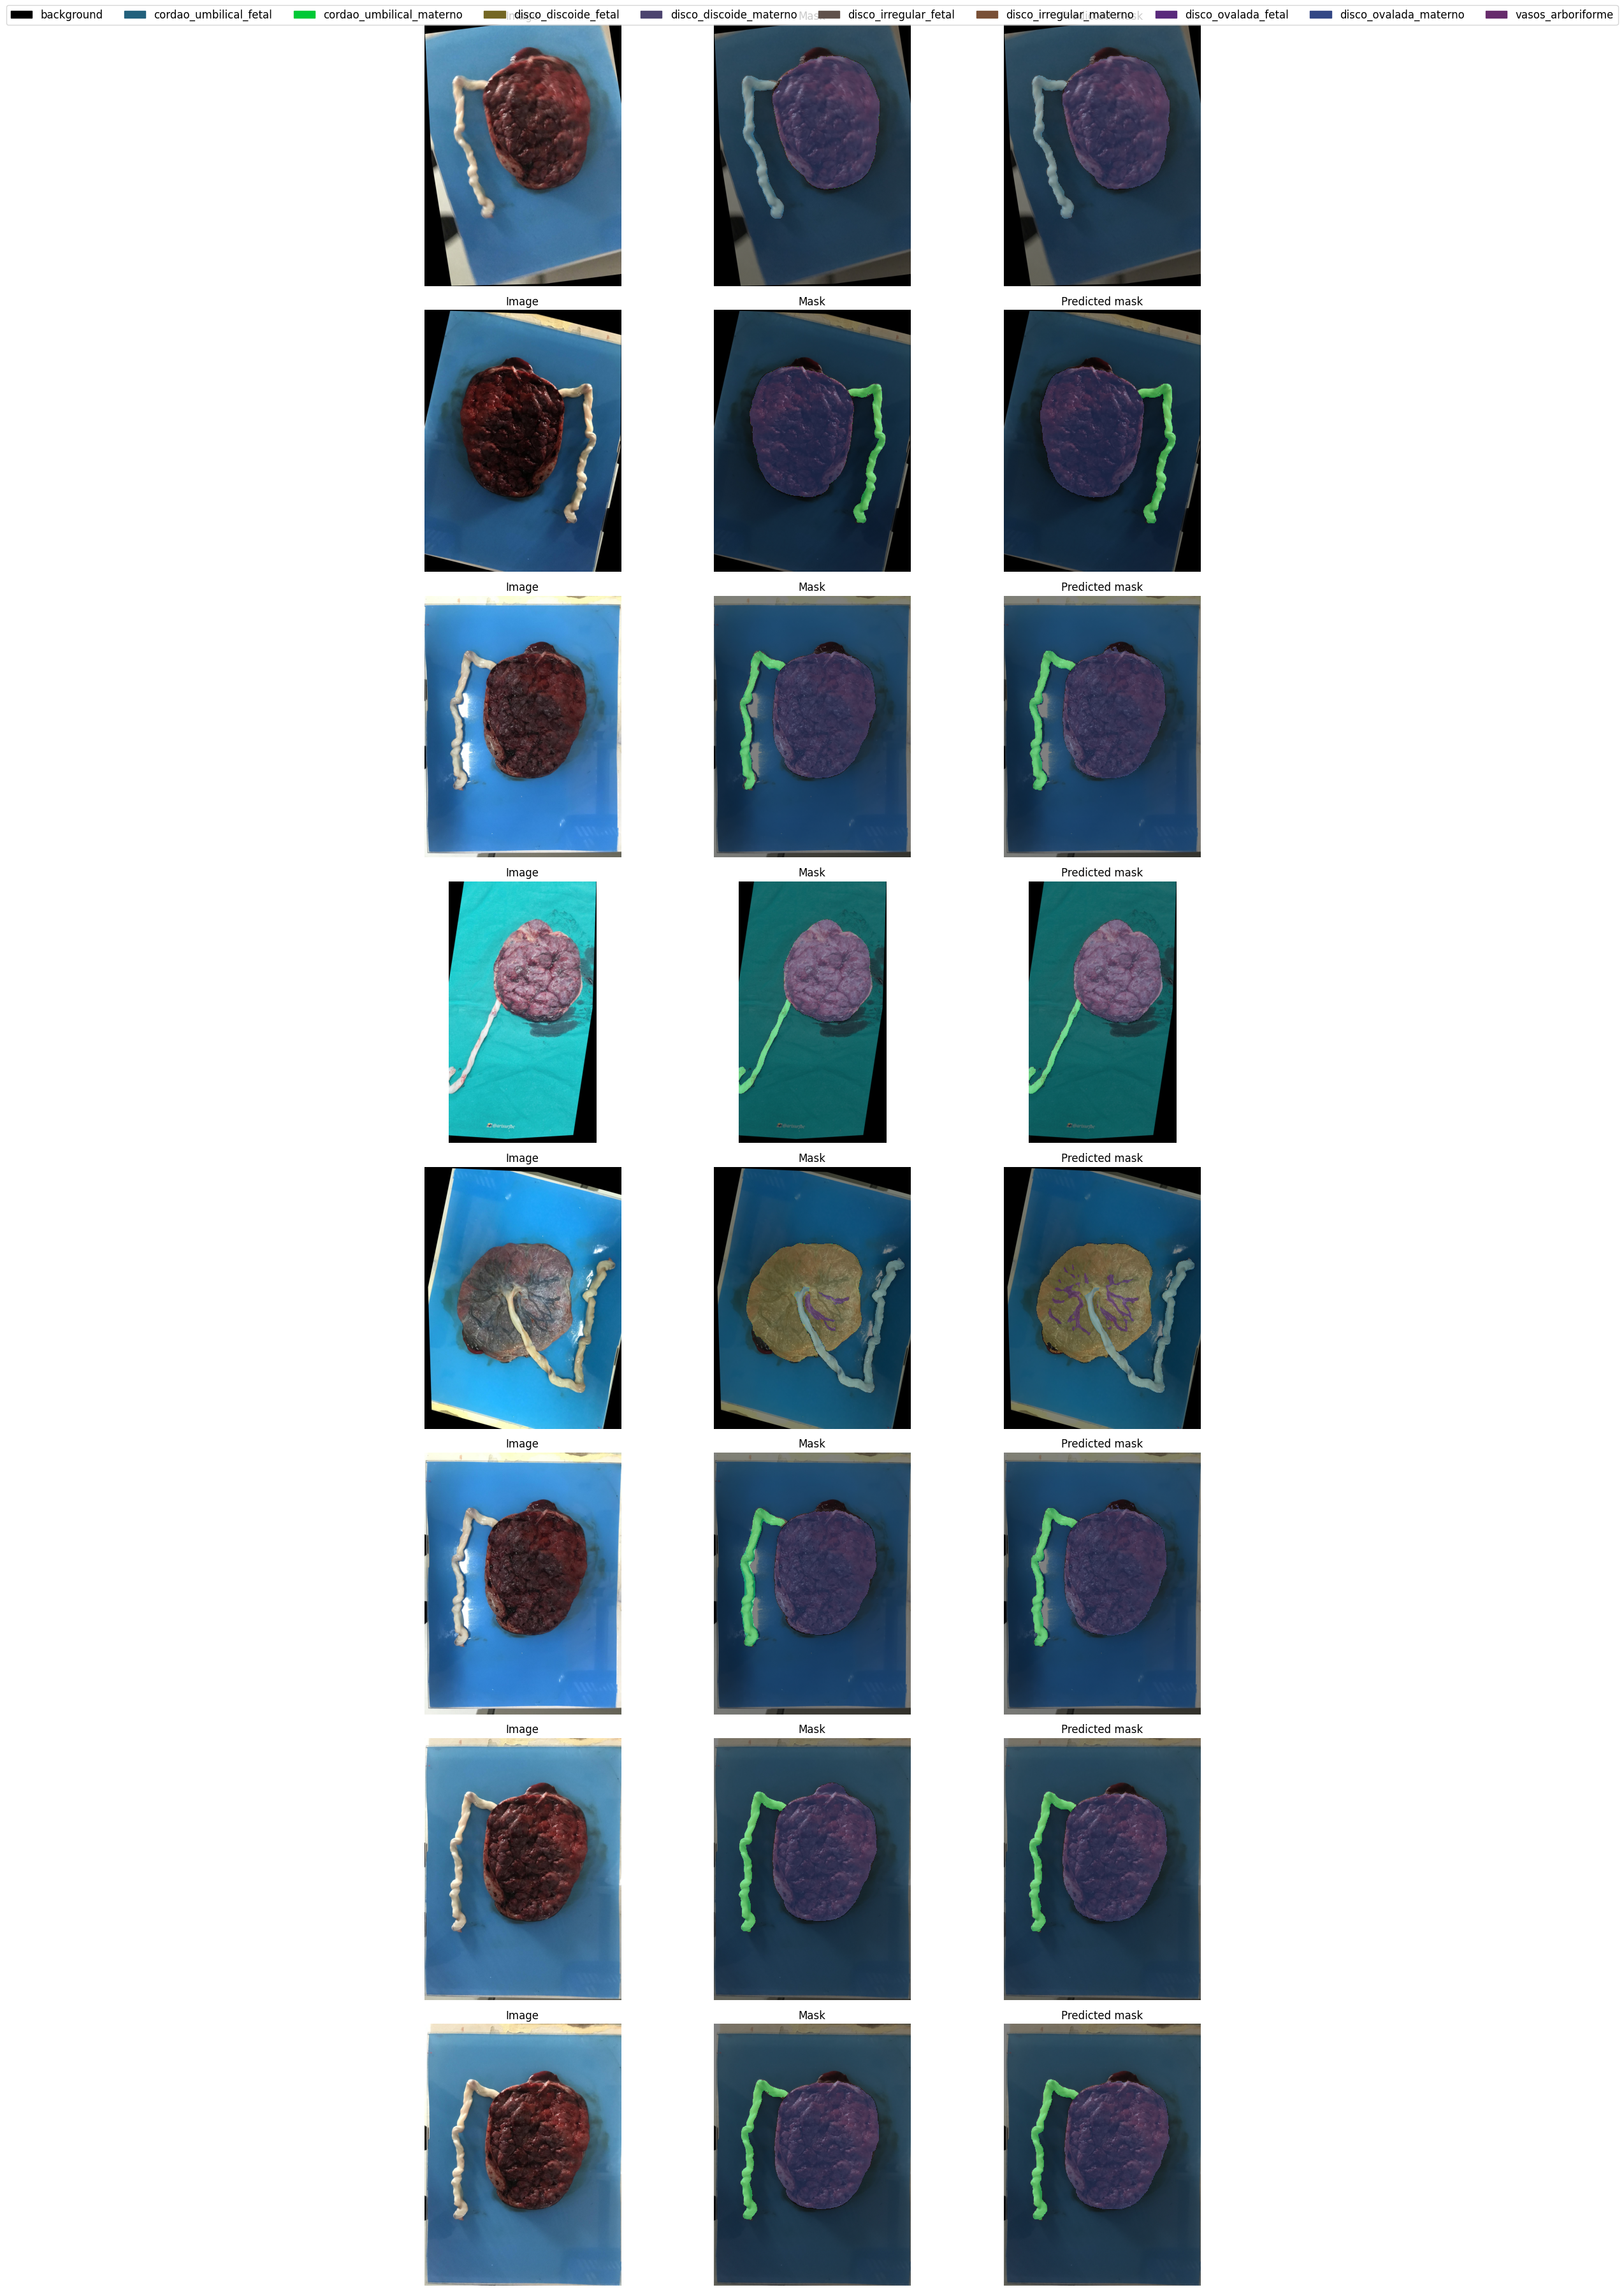

In [44]:
display_predictions(test_images_filenames, images_directory, masks_directory, predicted_masks, custom_colormap, mask_alpha=0.5, n_samples=8)

## Definindo método para gerar as predições

Nas células acima, foi criado um método que realiza predições e mostra aleatoriamente algumas imagens do conjunto de dados. Agora, o método `save_predictions` salva estas predições no Google Drive para uma análise mais aprofundada. Aqui, são feitas predições em todas as imagens do conjunto de teste.

In [45]:
def save_predictions(images_filenames, images_directory, masks_directory, predicted_masks):
    for i, index in enumerate(range(len(predicted_masks))):
        predicted_mask = predicted_masks[index]
        plt.imsave(os.path.join(PATH_TO_SAVE_MASK, images_filenames[index]), predicted_masks[index])
        print(f"[{i+1}/{len(predicted_masks)}] {os.path.join(PATH_TO_SAVE_MASK, images_filenames[index])}")

In [46]:
if GENERATE_MASKS:
    save_predictions(test_images_filenames, images_directory, masks_directory, predicted_masks)

[1/46] /lapix/compartilhado/beatriz/placenta/efficient/ResultadoImagens/20250904183935/efficientnetb0_10_classesmultiresolution_512_512_50_epochs/IMG_9914_jpg.rf.84b7b41290749def686036cc984e222f.jpg
[2/46] /lapix/compartilhado/beatriz/placenta/efficient/ResultadoImagens/20250904183935/efficientnetb0_10_classesmultiresolution_512_512_50_epochs/IMG_9915_jpg.rf.522d5e648b7704608609559bd96f5dda.jpg
[3/46] /lapix/compartilhado/beatriz/placenta/efficient/ResultadoImagens/20250904183935/efficientnetb0_10_classesmultiresolution_512_512_50_epochs/IMG_9915_jpg.rf.93ecb10d088e824a624e98625eb31caa.jpg
[4/46] /lapix/compartilhado/beatriz/placenta/efficient/ResultadoImagens/20250904183935/efficientnetb0_10_classesmultiresolution_512_512_50_epochs/IMG_9915_jpg.rf.d2d11e1fbff04dd2b20c96f798e6a420.jpg
[5/46] /lapix/compartilhado/beatriz/placenta/efficient/ResultadoImagens/20250904183935/efficientnetb0_10_classesmultiresolution_512_512_50_epochs/IMG_9916_jpg.rf.5823c3eb6275858c72c9e943c707f04b.jpg
[6/46

## Avaliação do modelo treinado
Nesta etapa é feita a avaliação do modelo treinado, levando em conta diversas métricas utilizadas no contexto de segmentação semântica. Para isso, são comparadas as anotações com as predições geradas pela rede neural. Para executar esta etapa, as células de predição (Seção **Definindo método para predição nas imagens de teste**, acima) devem ter sido executadas.

In [47]:
codes

array(['background', 'cordao_umbilical_fetal', 'cordao_umbilical_materno',
       'disco_discoide_fetal', 'disco_discoide_materno',
       'disco_irregular_fetal', 'disco_irregular_materno',
       'disco_ovalada_fetal', 'disco_ovalada_materno',
       'vasos_arboriforme'], dtype='<U24')

In [48]:
def get_ground_truths_and_predictions(images_filenames, masks_directory, predicted_masks):
    gt_masks = []
    prediction_masks = []
    for index in range(len(predicted_masks)):
        gt_masks.append(cv2.imread(os.path.join(masks_directory, images_filenames[index].replace(".jpg", "_mask.png")), cv2.IMREAD_UNCHANGED))
        prediction_masks.append(predicted_masks[index].astype(int))

    return gt_masks, prediction_masks

In [49]:
gt_masks, pred_masks = get_ground_truths_and_predictions(test_images_filenames, masks_directory, predicted_masks)

In [50]:
eval = evaluate_segmentation(gt_masks, pred_masks, codes)

0 masks [00:00, ? masks/s]

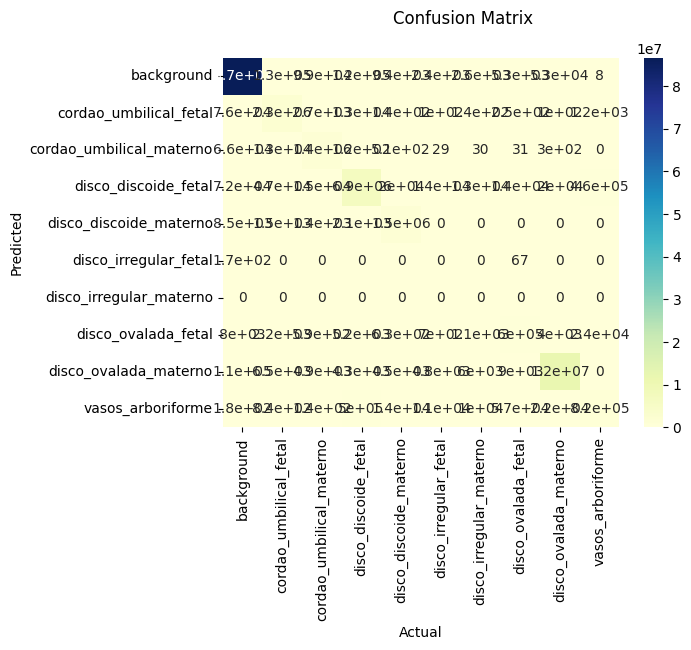

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Actual', ylabel='Predicted'>)

In [51]:
eval.show_confusion_matrix()

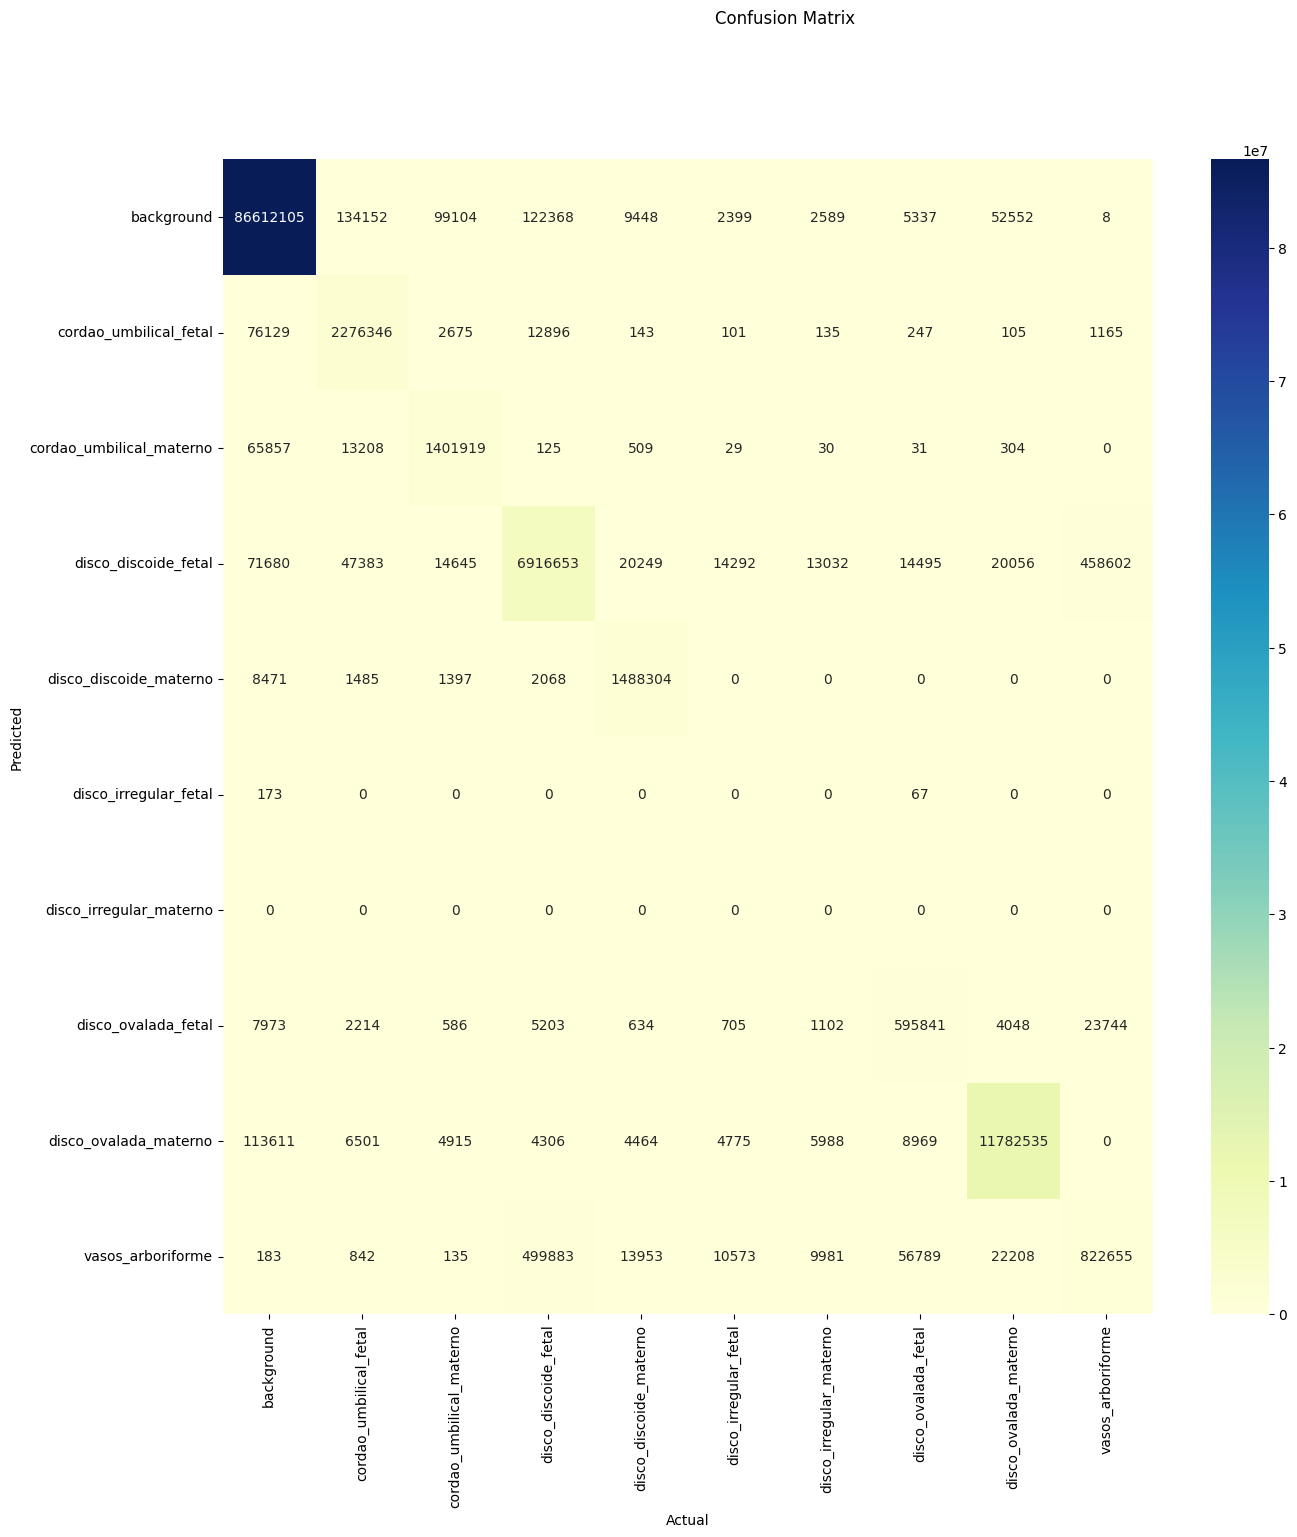

In [52]:
import pandas as pd
import seaborn as sn
import numpy as np
import os

df_cm = pd.DataFrame(eval.confusion_matrix, codes, codes)
fig, ax = plt.subplots()
fig.suptitle("Confusion Matrix")
fig.set_figheight(15)
fig.set_figwidth(15)
ax = sn.heatmap(df_cm, annot=True, ax=ax, cmap='YlGnBu',  fmt='d')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()